In [ ]:
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torchvision
import os
from PIL import Image
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import string
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("device is {}".format(device))

device is cuda


# Downloading Data

In [ ]:
!wget www.cse.iitb.ac.in/~gowthamsridhar/data.zip

--2023-11-26 22:26:13--  http://www.cse.iitb.ac.in/~gowthamsridhar/data.zip
Resolving www.cse.iitb.ac.in (www.cse.iitb.ac.in)... 103.21.127.134
Connecting to www.cse.iitb.ac.in (www.cse.iitb.ac.in)|103.21.127.134|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cse.iitb.ac.in/~gowthamsridhar/data.zip [following]
--2023-11-26 22:26:14--  https://www.cse.iitb.ac.in/~gowthamsridhar/data.zip
Connecting to www.cse.iitb.ac.in (www.cse.iitb.ac.in)|103.21.127.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1113116819 (1.0G) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.04G  14.0MB/s    in 1m 42s  

2023-11-26 22:27:57 (10.4 MB/s) - ‘data.zip’ saved [1113116819/1113116819]



In [ ]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/images/2844747252_64567cf14a.jpg  
  inflating: flickr8k/images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/images/2847514745_9a35493023.jpg  
  inflating: flickr8k/images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/images/2848266893_9693c66275.jpg  
  inflating: flickr8k/images/2848571082_26454cb981.jpg  
  inflating: flickr8k/images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/images/28491949

In [ ]:
input_dir = 'flickr8k/images/'
output_file = 'flickr8k/captions.txt'

In [ ]:
list_of_files = os.listdir(input_dir)

# Preprocessing Images

In [ ]:
def preprocess_images(input_dir):
  """
  input_dir : str : input_dir
  """
  preprocess = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
    ]
  )
  image = []
  for img_name in list_of_files:
    img = preprocess(Image.open(os.path.join(input_dir,img_name)))
    image.append(img)
  return torch.stack(image).to(device)

In [ ]:
def display_image(Images,num):
  T = transforms.ToPILImage()
  img = T(Images[num,:,:,:])
  plt.imshow(img)

In [ ]:
Images = preprocess_images(input_dir)
# Images /= 255
Images.size()

torch.Size([8091, 3, 224, 224])

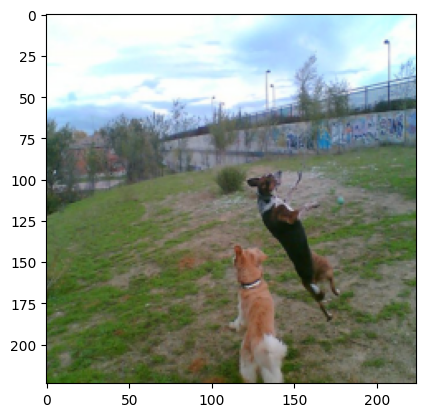

In [ ]:
display_image(Images,1)

# Preprocessing Captions

In [ ]:
start = "<start>"
end = "<end>"
unk = "<unk>"

In [ ]:
def preprocess_text(text):
  """
  remove the digits, punctuations and change all the punctuations and all words to lower case
  this is done to make all captions contain <start>, <end>, and words in lower case
  """
  text = re.sub(r'\d+', '', text)
  text = " ".join([i.strip(string.punctuation).lower() for i in text.split()])
  text = " ".join([i for i in text.split() if len(i) > 1])
  text = text.replace('\s+', ' ').replace('\n','')
  return text


In [ ]:
def preprocess_caption(output_dir):
  captions = open(output_dir, 'r').read().strip().split('\n')
  caption_dict = {}
  for row in captions[1:]:
      img_id, caption = row.split(',')[0],row.split(',')[1]
      caption = '<start> ' + preprocess_text(caption.strip()) + ' <end>'
      if img_id in caption_dict:
          caption_dict[img_id].append(caption)
      else:
          caption_dict[img_id] = [caption]

  return caption_dict

In [ ]:
def tokenise_captions(captions_set):
  int_to_word = {}
  word_to_int = {}
  total_words = []
  for captions in captions_set:
    for caption in captions:
      total_words += list(filter(None,caption.split(" ")))
  unique_words = list(set(total_words))
  word_to_int = dict([(words,index+3) for index,words in enumerate(unique_words)])
  int_to_word = dict([(index+3,words) for index,words in enumerate(unique_words)])
  word_to_int[start] = 0
  word_to_int[end] = 1
  word_to_int[unk] = 2
  int_to_word[0] = start
  int_to_word[1] = end
  int_to_word[2] = unk
  return int_to_word,word_to_int

In [ ]:
def encoding_captions(int_to_word, word_to_int,captions_set):
  encoded_captions = []
  for index,captions in enumerate(captions_set):
    for ind,caption in enumerate(captions):
      seq = []
      text = list(filter(None,caption.split(" ")))
      for word in text:
        if word in word_to_int.keys():
          seq.append(word_to_int[word])
        else:
          seq.append(word_to_int["<unk>"])
      encoded_captions.append((torch.tensor(seq)))
  return encoded_captions

In [ ]:
caption_dict = preprocess_caption(output_file)

# Train-Validation split

In [ ]:
train_split = int(0.8*len(list_of_files))
val_split = ((len(list_of_files) - train_split)//2 )
test_split = len(list_of_files) - train_split - val_split

train_files = list_of_files[:train_split]
validation_files = list_of_files[train_split:train_split+val_split]
test_files = list_of_files[train_split+val_split:]


train_images = Images[:train_split,:,:,:]
validation_images = Images[train_split:train_split+val_split,:,:,:]
test_images = Images[train_split+val_split:,:,:,:]


In [ ]:
train_captions = [caption_dict[file] for file in train_files]
vocab = tokenise_captions(train_captions)
encoded_train_captions = encoding_captions(vocab[0],vocab[1],train_captions)

In [ ]:
val_captions = [caption_dict[file] for file in validation_files]
encoded_val_captions = encoding_captions(vocab[0],vocab[1],val_captions)

['<start> man dressed in gray gear <end>', '<start> man in black uniform and helmet dirtracing with his bike front wheel in midair <end>', '<start> man riding dirt bike <end>', '<start> motorcycle racer is in action at the track <end>', '<start> biker riding dirt bike on dirt track <end>']


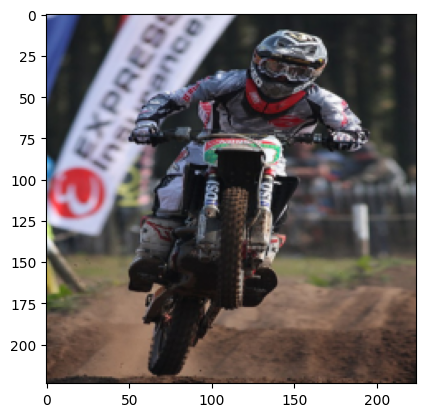

In [ ]:
print(train_captions[0])
display_image(train_images,0)

In [ ]:
print(train_images.shape)
print(len(vocab[0]))
print(len(train_files))
print((len(train_captions)))

torch.Size([6472, 3, 224, 224])
7777
6472
6472


# Captions Dataset

In [ ]:
class CaptionDataset(Dataset):
  def __init__(self,images,encoded_captions,split,captions_per_images):
    self.images = images
    self.captions = encoded_captions
    self.captions_per_images = captions_per_images
    self.split = split # "train","val" or "test"
    self.dataset_size = len(encoded_captions)

  def __len__(self):
    return self.dataset_size

  def get_train_indices(self):
    indices = []
    randomised_captions = np.random.choice(list(range(5)),len(self.images),replace = True)
    indices = randomised_captions + np.array(list(range(len(self.images))))*5
    return list(indices)

  def __getitem__(self,index):
    # print("index:",index//self.captions_per_images)
    img = self.images[(index//self.captions_per_images),:,:,:]
    caption = self.captions[index]
    # print(type(caption))
    caplen = len(caption)
    if self.split == "train":
      return img,caption,caplen
    else :
      return img,self.captions[(index // self.captions_per_images)*self.captions_per_images:((index // self.captions_per_images) + 1)*self.captions_per_images-1]


In [ ]:
train_dataset = CaptionDataset(train_images,encoded_train_captions,"train",5)
train_loader = DataLoader(train_dataset,shuffle = True)

In [ ]:
validation_captions = []
for caption_set in val_captions:
  for captions in caption_set:
    validation_captions.append(captions)
val_dataset = CaptionDataset(validation_images,validation_captions,"val",5)
val_loader = DataLoader(val_dataset)

In [ ]:
print(validation_captions)
for data in val_loader:
  print(data)
  break

['<start> dog in water holds stick in its mouth <end>', '<start> german shepherd is running with stick in its mouth <end>', '<start> large yellow dog is retrieving stick <end>', '<start> tan dog holding stick in his mouth <end>', '<start> the yellow dog is carrying stick by water <end>', '<start> group of dressed-up people talking <end>', '<start> group of five young people all dressed in black in dimlight room <end>', '<start> total of five people in black clothes are having conversations in plain white room <end>', '<start> three men and two women talking <end>', '<start> two groups of people dressed in black clothes and with brown hair <end>', '<start> brown dog digging for ball in the sand <end>', '<start> brown dog digs in the sand for an orange ball <end>', '<start> brown dog is trying to retrive his orange ball that has fallen in dirt hole <end>', '<start> dog burrowing in the dirt trying to get an orange ball <end>', '<start> dog digging for his ball in the sand <end>', '<start

# CNN encoder part of the model

In [ ]:
class CNN_model_1(nn.Module):
    #vgg 19
    def __init__(self, embed_size):
        super(CNN_model_1, self).__init__()
        vgg = models.vgg19(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad_(False)

        modules = list(vgg.children())[:-1]
        self.vgg = nn.Sequential(*modules)
        self.embed = nn.Linear(25088, embed_size)
        self.embed.weight.data.normal_(0.0, 0.02)
        self.embed.bias.data.fill_(0)

    def forward(self, images):
        features = self.vgg(images)
        features = features.reshape(features.size(0), -1)
        return self.embed(features)


In [ ]:
from torchvision.models.resnet import resnet152
class CNN_model_2(nn.Module):
  # ResNet model
  def __init__(self,embed_size):
    super(CNN_model_2,self).__init__()
    resnet = models.resnet152(pretrained = True)
    for param in resnet.parameters():
      param.requires_grad_(False)
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    self.linear = nn.Linear(resnet.fc.in_features,embed_size)
    self.linear.weight.data.normal_(0.0, 0.02)
    self.linear.bias.data.fill_(0)

  def forward(self, images):
    features = self.resnet(images)
    # print(features.shape)
    features = features.reshape(features.size(0), -1)
    # print(features.shape)
    return self.linear(features)

In [ ]:
class CNN_model_3(nn.Module):
  # Inception v3 model
  def __init__(self, embed_size):
        super(CNN_model_3, self).__init__()
        inception = models.inception_v3(pretrained=True)
        for param in inception.parameters():
            param.requires_grad_(False)

        modules = list(inception.children())[:-1]
        self.inception = nn.Sequential(*modules)
        self.embed = nn.Linear(inception.fc.in_features, embed_size)
        self.embed.weight.data.normal_(0.0, 0.02)
        self.embed.bias.data.fill_(0)

  def forward(self, images):
        features = self.inception(images)
        features = features.view(features.size(0), -1)
        return self.embed(features)

# LSTM and Transformer part of the decoder

In [ ]:
class LSTM_model_1(nn.Module):
  def __init__(self,embed_dim,hidden_dim,vocab_size,n_layers = 20):
    """
    embed_size : int : size of embedding
    hidden_dim : int : dimension of hidden layer in lstm
    vocab_size : int : size of vocabulary
    n_layers : int : number of layers
    """
    super(LSTM_model_1,self).__init__()
    self.embed_dim = embed_dim
    self.hidden_dim = hidden_dim
    self.vocab_size = vocab_size
    self.n_layers = n_layers
    self.embeddings = nn.Embedding(vocab_size,embed_dim)
    self.lstm = nn.LSTM(input_size = embed_dim,hidden_size = hidden_dim,num_layers = n_layers,batch_first = True)
    self.linear = nn.Linear(hidden_dim,vocab_size)
    self.dropout = nn.Dropout(p=0.4)
    self.softmax = nn.Softmax()

  def forward(self,features,captions):
    """
    X : tensor : input
    """
    captions = captions[:,:-1]
    embeddings = self.embeddings(captions)
    inputs = torch.cat((features.unsqueeze(1),embeddings),1)
    hidden = torch.randn(self.n_layers,len(inputs),self.hidden_dim).to(device)
    carry = torch.randn(self.n_layers,len(inputs),self.hidden_dim).to(device)
    output, (hidden,carry) = self.lstm(inputs,(hidden,carry))
    return self.linear(self.dropout(output[0]))
    # return self.linear(output)

  def sample(self,X,states = None,max_len = 20):
    """
    Greedy Search
    X : tensor : input
    States : (tensor,tensor) :
    """
    predicted_caption = []
    inputs = X
    for i in range(max_len):
      output, states = self.lstm(inputs,states)
      output = output.squeeze(1).squeeze(1)
      # output = self.softmax(self.linear(output))
      output = self.linear(output)
      target = output.max(1)[1]
      predicted_caption.append(target.item())
      inputs = self.embeddings(target).unsqueeze(1)
    return predicted_caption


# Integrating the 2 parts of the model

In [ ]:
class Model(nn.Module):
  def __init__(self,encoder,decoder,embed_size,hidden_size,vocab_size):
    """
    takes input for all the classes and creates the model
    """
    super(Model,self).__init__()
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,images,captions):
    features = self.encoder(images)
    outputs = self.decoder(features,captions)
    return features,outputs

  def evaluate_and_sample(self,image):
    features = self.encoder(image).unsqueeze(1)
    prediction = self.decoder.sample(features)
    return prediction


In [ ]:
def generate_captions(model,image):
  model.eval()
  predicted_captions = model.evaluate_and_sample(image)
  sentence = ""
  for idx in predicted_captions:
    word = vocab[0][idx]
    if word != "<end>" and word != '<start>':
      sentence += vocab[0][idx] + " "
    elif word == '<end>':
      break
  return sentence

In [ ]:
def validate(model):
  actual_captions = []
  generated_captions = []
  for data in val_loader:
    image, caption_set = data
    # print(image,caption_set)
    actual_captions.append([caption[0].split() for caption in caption_set])
    generated_captions.append(generate_captions(model,image).split())
  bleu1 = corpus_bleu(actual_captions, generated_captions, weights=(1.0, 0, 0, 0))
  bleu2 = corpus_bleu(actual_captions, generated_captions, weights=(0.5, 0.5, 0, 0))
  bleu3 = corpus_bleu(actual_captions, generated_captions, weights=(1/3, 1/3, 1/3, 0))
  bleu4 = corpus_bleu(actual_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))
  bleu = (bleu1*bleu2*bleu3*bleu4)**0.25
  print(f'BLEU-1: {bleu1}')
  print(f'BLEU-2: {bleu2}')
  print(f'BLEU-3: {bleu3}')
  print(f'BLEU-4: {bleu4}')
  print(f'BLEU:{(bleu1*bleu2*bleu3*bleu4)**0.25}')
  return bleu

In [45]:
def train(model,lossfn,optimizer,train_loader,validation_loader = None,num_epochs = 30):
      model.train()
      best_checkpoint_model,best_bleu = None,0
      for epoch in range(1, num_epochs+1):
            model.train()
            average_loss = 0
            count = 0
            average_perp = 0
            indices = train_loader.dataset.get_train_indices()
            new_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices=indices)
            train_loader.batch_sampler.sampler = new_sampler
            for i,(img,cap,caplen) in tqdm(enumerate(train_loader)):
                img = img.to(device)
                cap = cap.to(device)
                model.zero_grad()
                features,outputs = model(img,cap)
                loss = lossfn(outputs.view(-1, model.vocab_size), cap.view(-1))
                loss.backward()
                optimizer.step()
                # if i%100 == 0:
                #   print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch,num_epochs,i,len(train_loader),loss.item(), np.exp(loss.item())))
                count += 1
                average_loss += loss.item()
            average_loss = average_loss/count
            average_perp = np.exp(average_loss)
            print('Epoch [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch,num_epochs,average_loss, average_perp))
            bleu = validate(model)
            if bleu > best_bleu:
              print("checkpointing best model")
              best_checkpoint_model = model
              best_bleu = bleu
      return model,best_checkpoint_model

        # # Print training statistics (on same line).
        #     # print('\r' + stats, end="")
        #     # sys.stdout.flush()

        #     # # Print training statistics to file.
        #     # f.write(stats + '\n')
        #     # f.flush()

        #     # # Print training statistics (on different line).
        #     # if i_step % print_every == 0:
        #     #     print('\r' + stats)

        # # Save the weights.
        # if epoch % save_every == 0:
        #     torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        #     torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Calling Functions

In [46]:
learning_rate = 0.0001
num_epochs = 10
embed_size=512
hidden_size=512
vocab_size=len(vocab[0])
print(vocab_size)
n_layers=2

7777


In [48]:
decoder = LSTM_model_1(embed_size,hidden_size,vocab_size,n_layers)
# decoder = Transformer_model_1(embed_size,hidden_size,vocab_size,n_layers)
encoder = CNN_model_1(embed_size=embed_size)
model = Model(encoder,decoder,embed_size,hidden_size,vocab_size)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [50]:
train(model,loss_fn,optimizer,train_loader,val_loader,num_epochs = 10)

6472it [02:16, 47.52it/s]


Epoch [1/10], Loss: 4.6741, Perplexity: 107.1404
BLEU-1: 0.3090822829237915
BLEU-2: 0.16941186507652733
BLEU-3: 0.08202204328981481
BLEU-4: 0.038287917707795965
BLEU:0.11324070558387514
checkpointing best model


6472it [02:11, 49.28it/s]


Epoch [2/10], Loss: 4.0096, Perplexity: 55.1240
BLEU-1: 0.3787594214251155
BLEU-2: 0.19319402873185418
BLEU-3: 0.09707861990636234
BLEU-4: 0.05119268707962629
BLEU:0.13809315938935857
checkpointing best model


6472it [02:11, 49.33it/s]


Epoch [3/10], Loss: 3.8400, Perplexity: 46.5275
BLEU-1: 0.36443693225539586
BLEU-2: 0.19050124199441704
BLEU-3: 0.09646419020268152
BLEU-4: 0.05161471346179194
BLEU:0.13635308216159173


6472it [02:11, 49.07it/s]


Epoch [4/10], Loss: 3.7075, Perplexity: 40.7512
BLEU-1: 0.34859806048636627
BLEU-2: 0.1815767850444907
BLEU-3: 0.09171104468735565
BLEU-4: 0.048480046537432576
BLEU:0.12952168608968867


6472it [02:11, 49.38it/s]


Epoch [5/10], Loss: 3.6082, Perplexity: 36.9014
BLEU-1: 0.3492475049147758
BLEU-2: 0.18553583706295562
BLEU-3: 0.09657632618611012
BLEU-4: 0.05102844130266926
BLEU:0.1336783344402029


6472it [02:10, 49.49it/s]


Epoch [6/10], Loss: 3.5383, Perplexity: 34.4095
BLEU-1: 0.35738962130813995
BLEU-2: 0.18697823068700417
BLEU-3: 0.09441441093013918
BLEU-4: 0.04689721683560675
BLEU:0.1311534094554062


6472it [02:11, 49.17it/s]


Epoch [7/10], Loss: 3.4763, Perplexity: 32.3396
BLEU-1: 0.3398653743211692
BLEU-2: 0.18303321770995593
BLEU-3: 0.0962720323216391
BLEU-4: 0.05148889518654271
BLEU:0.13251426653643153


6472it [02:11, 49.33it/s]


Epoch [8/10], Loss: 3.4154, Perplexity: 30.4296
BLEU-1: 0.3588604009857802
BLEU-2: 0.19452068235244166
BLEU-3: 0.10578707627209911
BLEU-4: 0.056600253859761925
BLEU:0.14298338650723494
checkpointing best model


6472it [02:11, 49.11it/s]


Epoch [9/10], Loss: 3.3911, Perplexity: 29.6985
BLEU-1: 0.350239824507728
BLEU-2: 0.18966285297555616
BLEU-3: 0.10123109686497063
BLEU-4: 0.05290934665486283
BLEU:0.13734047236093122


6472it [02:11, 49.23it/s]


Epoch [10/10], Loss: 3.3420, Perplexity: 28.2760
BLEU-1: 0.32424692578693914
BLEU-2: 0.1783372215858074
BLEU-3: 0.10226962125639795
BLEU-4: 0.05652214186772117
BLEU:0.13521372597369097


(Model(
   (encoder): CNN_model_1(
     (vgg): Sequential(
       (0): Sequential(
         (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (1): ReLU(inplace=True)
         (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (3): ReLU(inplace=True)
         (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (6): ReLU(inplace=True)
         (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (8): ReLU(inplace=True)
         (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (11): ReLU(inplace=True)
         (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (13): ReLU(inplace=True)
         (14): Conv2d(256, 256, kernel_size=(3, 3),

# Generating Captions

In [51]:
def generate_captions_for_random_image(model):
    index = np.random.choice(len(validation_images),1,replace = True)
    image = validation_images[index,:,:,:]
    captions = generate_captions(model,image)
    print(captions)
    T = transforms.ToPILImage()
    img = T(image.squeeze())
    plt.imshow(img)

man in blue shirt and white shirt is standing on his head and is standing in front of crowd 


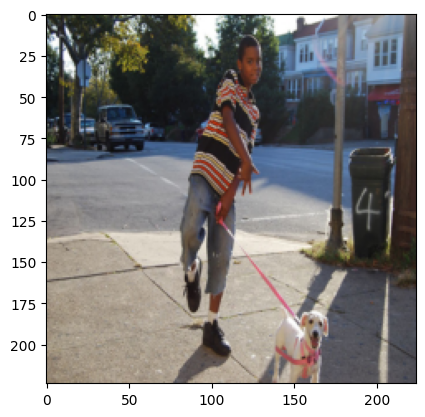

In [71]:
generate_captions_for_random_image(model)

boy in blue shirt 


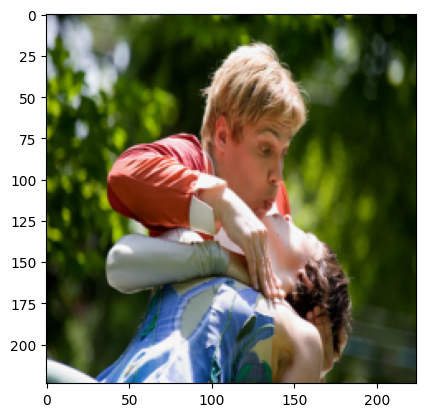

In [53]:
generate_captions_for_random_image(model)

man is jumping off the beach 


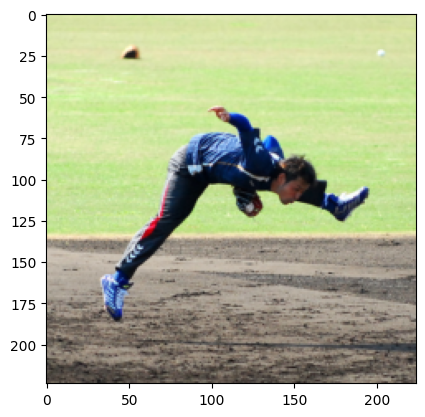

In [54]:
generate_captions_for_random_image(model)

two dogs are running in field 


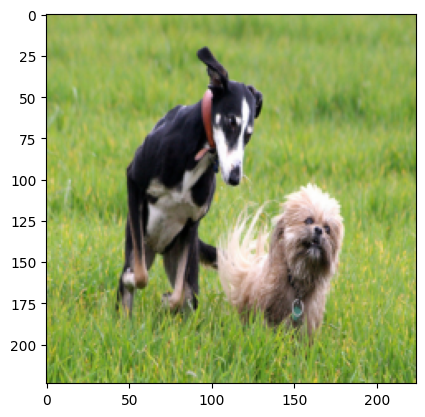

In [56]:
generate_captions_for_random_image(model)

boy in blue shirt and blue shirt 


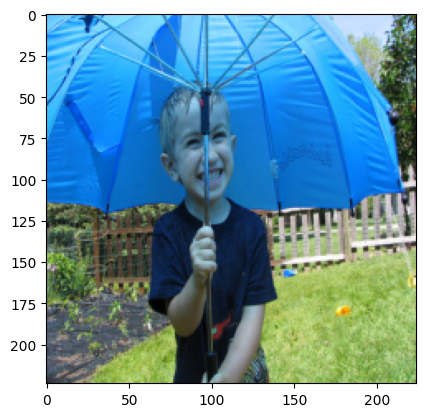

In [60]:
generate_captions_for_random_image(model)

dog running through the grass 


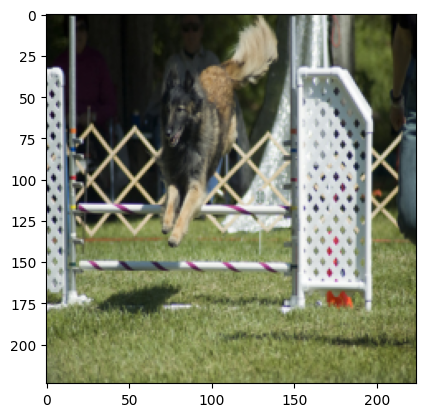

In [70]:
generate_captions_for_random_image(model)